In [5]:
! pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [11]:
import pandas as pd

#processed_file = "peft_distilled_eval_processed_parallel.json"
processed_file = "peft_quantized_eval_processed_parallel.json"
#processed_file = "eval_processed_parallel.json"
uf_n=40

llm_results = pd.read_json(processed_file, lines=True)
#print(llm_results.iloc[0]['results']['input'])
llm_results['results'] = [[[movie[0].removeprefix("Movie name: ")] for movie in m_list['rating']] for m_list in llm_results['results']]
print(llm_results.iloc[0]['results'])

eval_dataset = pd.read_json(f"TTE_uf{uf_n}/TTE_with_IO_eval.json")
#print(eval_dataset.iloc[0]['input'])
#print(eval_dataset.iloc[0]['output'])

def split_list(text, start_token, end_token):
    phrase = text.split(start_token + "\n")
    movie_list = phrase[1].split("\n" + end_token)[0]
    movie_list = movie_list.split("\n")
    for i, movie in enumerate(movie_list):
        movie_list[i] = movie.split("\t")
    return movie_list

eval_dataset['user_out_list'] = [split_list(x, "%% START RECOMMENDED LIST %%", "%% END LIST %%") for x in eval_dataset['output']]
eval_dataset['user_out_list'] = [[[movie[0].removeprefix("Movie name: ")] for movie in m_list] for m_list in eval_dataset['user_out_list']]
print(eval_dataset.iloc[0]['user_out_list'])

pd_data = pd.DataFrame()
pd_data["sorted_candidates"] = eval_dataset['user_out_list']
pd_data["relevant_movies"] = pd_data["sorted_candidates"].apply(lambda data: data[:10])
pd_data["sorted_rating"] = llm_results['results']
print(pd_data.head(1))



[['Tarzan (1999)'], ['Shanghai Noon (2000)'], ['Antz (1998)'], ['Hunchback of Notre Dame, The (1996)'], ['Hercules (1997)'], ['Mulan (1998)'], ['Beauty and the Beast (1991)'], ['Toy Story (1995)'], ['Close Shave, A (1995)'], ["Bug's Life, A (1998)"], ['Hackers (1995)'], ['Hideaway (1995)'], ['Toy Story 2 (1999)'], ['Hudsucker Proxy, The (1994)'], ['Mulan (1998)'], ['Rosencrantz and Guildenstern Are Dead (1990)'], ['Shanghai Noon (2000)'], ['Mulan (1998)'], ['Hercules (1997)'], ['Beauty and the Beast (1991)'], ['Toy Story (1995)'], ['Mulan (1998)'], ['Toy Story 2 (1999)'], ['Antz (1998)'], ['Hackers (1995)'], ['Hunchback of Notre Dame, The (1996)'], ["Bug's Life, A (1998)"], ['Toy Story (1995)'], ['Hudsucker Proxy, The (1994)'], ['Shanghai Noon (2000)'], ['Rosencrantz and Guildenstern Are Dead (1990)'], ['Mulan (1998)'], ['Hercules (1997)'], ['Beauty and the Beast (1991)'], ['Toy Story (1995)'], ['Antz (1998)'], ['Mulan (1998)'], ['Close Shave, A (1995)'], ['Hunchback of Notre Dame, The

In [12]:
print(pd_data["sorted_rating"].apply(len))

np_array = pd_data["sorted_rating"].apply(len).values
total = sum([1 if x<10 else 0 for x in np_array])
print(total)

0       49
1       48
2       21
3       44
4       47
        ..
4425    48
4426    44
4427    51
4428    39
4429    49
Name: sorted_rating, Length: 4430, dtype: int64
0


In [13]:
def correct_list(list_of_films):
    if len(list_of_films) < 10:
        new_list = list_of_films
        while len(new_list)<10 :
            new_list.append([""])
        return new_list
    else:
        return list_of_films

pd_data["sorted_rating"] = pd_data["sorted_rating"].apply(correct_list)


In [14]:
from tabulate import tabulate
import math

avgs = [[0 for n_rel in range(10)] for k_i in [1,5,10]]

for k_i in [1,5,10]:
    for n_rel in range(10):
        
        def hit_rate_at_k(predicted_ranking, relevant_items, k):
            top_k = set(predicted_ranking[:k])
            return 1 if top_k.intersection(relevant_items[:n_rel+1]) else 0
        
        def hit_rate_for_row(row):
            ratings = [movie for [movie] in row['sorted_rating']]
            rel_item = [movie for [movie] in row["relevant_movies"]]
            return hit_rate_at_k(ratings, rel_item, k_i)
        
        pd_data["hit_rate"] = pd_data.apply(hit_rate_for_row, axis=1)
        avg = pd_data["hit_rate"].mean()
        avgs[int(k_i/5)][n_rel] = math.trunc(avg * 10_000) / 10_000
        # print(avg)

# print(avgs)

print(tabulate(
    avgs,
    headers=[f"#RI {n+1}" for n in range(10)],
    showindex=[f"HitRate@{k}" for k in [1,5,10]],
    tablefmt="grid"
))

+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+
|            |   #RI 1 |   #RI 2 |   #RI 3 |   #RI 4 |   #RI 5 |   #RI 6 |   #RI 7 |   #RI 8 |   #RI 9 |   #RI 10 |
+============+=========+=========+=========+=========+=========+=========+=========+=========+=========+==========+
| HitRate@1  |  0.8293 |  0.8801 |  0.8801 |  0.8801 |  0.8801 |  0.8851 |  0.8851 |  0.8851 |  0.8855 |    0.886 |
+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+
| HitRate@5  |  0.8451 |  0.9751 |  1      |  1      |  1      |  1      |  1      |  1      |  1      |    1     |
+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+
| HitRate@10 |  0.9365 |  0.9961 |  1      |  1      |  1      |  1      |  1      |  1      |  1      |    1     |
+------------+---------+---------+---------+---------+---------+--------

In [15]:
import numpy as np

def dcg_at_k(relevances, k):
    relevances = np.array(relevances[:k])
    return np.sum(relevances / np.log2(np.arange(2, k + 2)))

def ndcg_at_k(predicted_ranking, relevance_dict, k):
    rel_pred = [relevance_dict.get(item, 0) for item in predicted_ranking]
    dcg = dcg_at_k(rel_pred, k)
    ideal_rel = sorted(relevance_dict.values(), reverse=True)
    idcg = dcg_at_k(ideal_rel, k)
    return dcg / idcg if idcg > 0 else 0

def ndcg_for_row(row):
    predicted = [movie for [movie] in row['sorted_rating']]
    relevance_dict = {movie:1 for [movie] in row["sorted_candidates"]}  # Others default to 0
    k = 10
    ndcg = ndcg_at_k(predicted, relevance_dict, k)
    return ndcg

pd_data["ndcg"] = pd_data.apply(ndcg_for_row, axis=1)

#ndcg_for_row(pd_data.loc[0])
print(pd_data.head(1))
avg = pd_data["ndcg"].mean()
print(avg)

                                   sorted_candidates  \
0  [[Tarzan (1999)], [Close Shave, A (1995)], [An...   

                                     relevant_movies  \
0  [[Tarzan (1999)], [Close Shave, A (1995)], [An...   

                                       sorted_rating  hit_rate  ndcg  
0  [[Tarzan (1999)], [Shanghai Noon (2000)], [Ant...         1   1.0  
0.9820444261347765


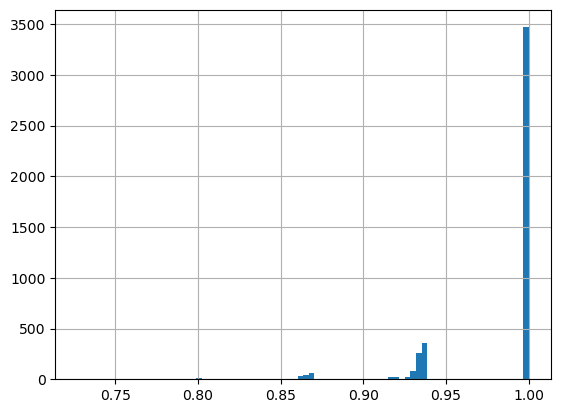

In [16]:
import matplotlib.pyplot as plt

(pd_data[pd_data['ndcg'] > 0])['ndcg'].hist(bins=80)
#pd_data['ndcg'].hist(bins=80)
plt.show()